# Stock Price Predictor

### Objective:
This Jupyter notebook has been prepared to predict stock prices given one or more stock ticker symbols to download historical stock price data and some user inputs for the training period, forecast interval and the date for which prediction should be generated.

### Instructions:
1. Run all the code cells in section 1. to 5. as per the table of contents below to initialize the class, functions and inputs required to generate predictions in the USER INTERFACE section
2. Proceed to section 6. - USER INTERFACE and follow steps 6a. to 6d. to walkthrough the steps to supply the inputs required to generate the prediction.

### Caution:
Predicting stock prices can be a perilous exercise. The stock market can have days like the one in the image below when everything is taking a nosedive. Proceed with caution and weigh other inputs including your risk tolerance and your expected investment horizon before trading on stock predictions generated by any model. 


  <a> <img src="Image 1 - Intro jupyter notebook.JPG" style="width: 750px; height:350px; float: center"></a>

### Table of Content<a name="itemA"></a>


1. <a href="#item1">Import required libraries</a>
2. <a href="#item2">Setting up utility/helper functions for data import and preparation</a>
3. <a href="#item3">Importing data</a>
4. <a href="#item4">Data Exploration and Visualization</a>
5. <a href="#item5">Data Preprocessing and Featuring Engineering</a>
6. <a href="#item6">Setting up learner class to help fit/train model and generate predictions</a>
7. <a href="#item7">Setting up utility/helper functions for model training and evaluation</a>
8. <a href="#item8">Training and evaluating the models</a>
9. <a href="#item9">USER INTERFACE - Generating predictions</a>
    * 9a. <a href="#item9a">Get user input on the list of ticker symbols for prediction</a>
    * 9b. <a href="#item9b">Get user input on the date range to be used for training and testing</a>
    * 9c. <a href="#item9c">Get user input on the forecast interval</a>
    * 9d. <a href="#item9d">Train models and determine the best model to be used for prediction</a>
    * 9e. <a href="#item9e">Get user input on the date for which prediction should be generated</a>
    * 9f. <a href="#item9f">Generate and present prediction for date specified by user</a>
   

## 1. Importing Required Libraries<a name="item1"></a>
<a href="#itemA">*`Table of content`*</a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from datetime import datetime, timedelta
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import linear_model
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

import warnings

# supress svm ConvergenceWarning to increase iterations. Already set to max_iter=10000 
warnings.filterwarnings('ignore', category=UserWarning) 


## 2. Setting up utility/helper functions for data import and preparation<a name="item2"></a>
<a href="#itemA">*`Table of content`*</a>

The following cell sets up some helper functions that will be used in the data import and preparation process.

See the respective docstrings for each function's purpose, inputs and outputs

In [2]:
def get_data(symbols):
    
    """Get prices for ticker symbols provided over the date range given by start and end dates
    
    Input: symbols - (str or list) ticker(s) of stocks for which prices are required
               
    Output: Series of stock prices if one ticker provided
            Dataframe of stock prices if list of tickers is provided 
    """
    
    is_single_ticker = False #initialize flag for single ticker request
    
    # if symbols is a list containing more than 1 tickers combine to one string
    # yfinance takes list as one string with tickers separated by space
    # for example ['GOOG', 'AAPL'] should be passed as 'GOOG AAPL'
         
    if len(symbols) > 1:
        symbols = ' '.join(map(str, symbols))
    else:       
        is_single_ticker = True   # flag if only one ticker symbol was provided. used later
    
    # API call to Yahoo Finance
    df = yf.download(symbols, period='max', group_by='ticker')
    
    # This section retains the multi-index column structure for consistency (if one ticker is requested)
    # yfinance does not return a multi-index structure if one ticker is requested
    
    if is_single_ticker:    
              
        # create list containing 6 identical elements representing the symbol
        # 5 because the API column return 6 columns and symbols already contains 1 column
        # hence 5 repeats needed to align with the 6 columns returned
        
        symbols.extend([symbols[0] for i in range(5)]) 
                
        # create multi-index column hierarchy
        tuples = tuple(zip(symbols, df.columns))
               
        # convert column index to a multi-index structure
        df.columns = pd.MultiIndex.from_tuples(tuples)
    
    return df

def format_tickers(tickers):
    
    """Formats the user entry into a list of tickers without punctuation and extra spaces
    
    Input: tickers (str) a string representing ticker symbols for which stock data is requested
    
    Output: clean_tickers (list) a list representing the list of stock tickers 
    
    """
    
    # Keep alphabetic characters and '-', remove all other characters 
    # also remove trailing spaces with strip()
    cleaned_tickers = re.sub("[^a-zA-z-]"," ", tickers).strip()
    
    # convert symbol to uppercase in case user entered as lower case
    # this is for consistency with calls for multiple tickers which display tickers as uppercase
    cleaned_tickers = cleaned_tickers.upper().split(" ")
    
    # for certain inputs, split function above may add additional blank elements
    # use list comprehension to retain elements that are not blanks ('')
    cleaned_tickers = [x for x in cleaned_tickers if x != '']
    
    return cleaned_tickers

def plot_data(df, figsize, title="Stock Prices", xlabel="Date", ylabel="Price"):
    """ Plot stock prices
    Input: df - dataframe with stock prices for single or multiple stocks
    Output: None - function only plots the stock prices
    """
    
    df.dropna(how='any', inplace=True)
    
    ax = df.plot(title=title, fontsize=12, figsize=figsize)
       
    # add axis labels    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
 
    plt.show();

def get_rolling_mean(values, window):
    """Return rolling mean of given values, using specified window size."""
    return values.rolling(window=window).mean()

def get_rolling_exponential_mean(values, span):
    """Return rolling mean of given values, using specified window size."""
    return values.ewm(span=span).mean()

def get_rolling_std(values, window):
    """Return rolling standard deviation of given values, using specified window size."""
    return values.rolling(window=window).std()

def create_features(df, forecast_range=28):
    
    """Creates new columns for features to be used for modelling
    
    Input: df (dataframe) representing the adjusted closing prices
           forecast_range (int) number of days in the future to be predicted
               
    Output: df_features (dataframe) which adds the following columns:
            1. forward price: this the value to be predicted (Y-value)
            2. rolling_mean: moving average over the forecast period
            3. sma_50: 50-day simple moving average (sma)
            4. sma_100: 100-day simple moving average (sma)
            5. rolling_std: moving standard deviation over the forecast period
            6. exponential_rolling_mean: exponential average over the forecast period
    """
    
    df_features = df.copy()    
    
    # forward fill
    # not using backfill after 'ffill' since remaining NaNs represent period before stock started trading
    df_features.fillna(method='ffill', inplace=True)
    
    df_features['forward_price'] = df_features['Adj Close'].shift(-forecast_range)
    df_features['rolling_mean'] = get_rolling_mean(df, forecast_range)
    df_features['sma_50'] = get_rolling_mean(df, 50)
    df_features['sma_100'] = get_rolling_mean(df, 100)
    df_features['rolling_std'] = get_rolling_std(df, forecast_range)
    df_features['exponential_rolling_mean'] = get_rolling_exponential_mean(df, forecast_range)
    df_features.dropna(how='any', inplace=True)
    
    return df_features

def get_returns(df):
    """Return the period returns for a given time series"""
   
    # calculate returns for each row by diving closing price by previous period closing
    # df.shift(0) gives the previous period closing
    
    df_returns = (df / df.shift(1)) - 1
    
    # replace values in first row with 0 
    # since first row will have NaN because it has no previous period closing
    df_returns.replace(to_replace=np.nan, value = 0, inplace=True)
    
    return df_returns

def get_cumulative_returns(df):
    """Return the cumulative returns over a given time series"""
    
    try:
        cum_returns = (df / df.iloc[0, :]) - 1    
    except:
        cum_returns = (df / df[0]) - 1
         
    return cum_returns


## 3. Importing data<a name="item3"></a>
<a href="#itemA">*`Table of content`*</a>


We use the API from the yfinance package to download prices from Yahoo Finance.

The function ```get_data``` was created in section 2. above to abstract away some of the steps required to compile and make the call to yfinance in the expected format to ensure a successful download

In [3]:
# import data from yahoo finance using the get_data helper function created above
tickers = ['XOM', 'AAPL', 'MSFT', 'GOOG']

# get stock data from yahoo finance using get_data function above
df = get_data(tickers)

# print number of rows in dataset
print("\nThere are {} tradings days worth of data\n".format(df.shape[0]))

display(df.head())

[*********************100%***********************]  4 of 4 completed

There are 15119 tradings days worth of data



GOOG                                 MSFT                 ... AAPL  \
           Open High Low Close Adj Close Volume Open High Low Close  ...  Low   
Date                                                                 ...        
1962-01-02  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   NaN  ...  NaN   
1962-01-03  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   NaN  ...  NaN   
1962-01-04  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   NaN  ...  NaN   
1962-01-05  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   NaN  ...  NaN   
1962-01-08  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   NaN  ...  NaN   

                                   XOM                                \
           Close Adj Close Volume Open      High       Low     Close   
Date                                                                   
1962-01-02   NaN       NaN    NaN  0.0  1.589844  1.578125  1.578125   
1962-01-03   NaN       NaN    NaN  0.0  1.601563  1.578125  1.601563   
1962-01-04   NaN       NaN    NaN  0.0  1.613281  1.597656  1.605469   
1962-01-05   NaN       NaN    NaN  0.0  1.613281  1.566406  1.570313   
1962-01-08   NaN       NaN    NaN  0.0  1.582031  1.546875  1.566406   

                               
           Adj Close   Volume  
Date                           
1962-01-02  0.102984   902400  
1962-01-03  0.104513  1200000  
1962-01-04  0.104768  1088000  
1962-01-05  0.102474  1222400  
1962-01-08  0.102219  1388800  

[5 rows x 24 columns]

## 4. Data Exploration and Visualization<a name="item4"></a>
<a href="#itemA">*`Table of content`*</a>


We receive data on the Open, High, Low, Close, Adj Close and Volume for each ticker. Our target variable of interest is the 'Adj Close'

We plot all the columns in the dataset for a given ticker symbol to view the historical time series using the plot_data helper function set up in part 2. above. This shows us that the other data points in the dataset are unlikely to be useful for predicting stock values. These features will therefore be removed from the dataset. The reason for removing these features in due to the fact that the open, high, low, and close are not adjusted for corporate actions such as dividends and stock splits and can be misleading in assessing the historical performance of a stock. The volume is also excluded for similar reasons as well as the fact that volume is also subject to fluctuations that are not related to the stock price.


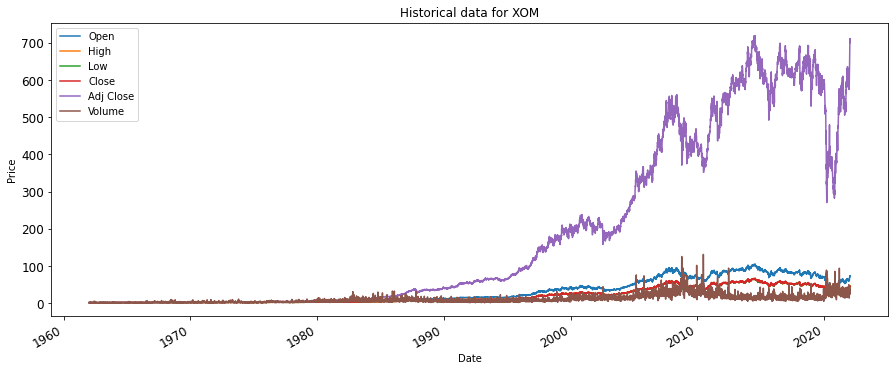

In [4]:
df_xom = df['XOM'].dropna(how='any')
df_xom['Open'].mask(df_xom['Open'] == 0, 1, inplace=True)
df_xom.fillna(method='ffill', inplace=True)
xom_data = pd.DataFrame(df_xom/df_xom.iloc[0,:]) 

plot_data(xom_data, figsize=(15,6), title='Historical data for XOM')

Investors in the stock market will either use fundamental analysis or technical analysis to make decisions about which stocks to buy or sell. We considered using fundamental analysis as there is a track record of investors beating the average return on the stock market using this approach. The classic case in favor of fundamental analysis is the long-term record of Warren Buffet and other star hedge fund or mutual fund managers. This approach requires analysis of a company's financial statement and other business factors to make predictions about the future performance of the stock. Given that we wish to build a stock predictor that allows the user to provide input on which stocks they wish to generate predictions for, the stock forecast interval and the period they wish to train the model a fundamental analysis approach is not feasible as this requires bespoke analysis for each stock. 

In order to deliver a more general approach that allows more flexibility we limited our approach to technical analysis. Technical analysis uses patterns in the stock price to determine the path that future stock prices are expected to take. Technical analysis has various themes that we can focus on which include momentum, support and resistance, trend, volatility and volume. We determined to focus on volatility and trend as these were considered more reliable for generating more consistent results over varying forecast intervals. Support and resistance and momentum indicators tend to be more relevant over shorter periods and provide less predictive value over longer forecast periods. Volume was also disregarded as the data source used to source historical data does not normalize volume data for the corporate actions that can affect the level of trading volume.

The following volatility and trend indicators were considered and visualized in the plot below.
1. Rolling mean (simple moving average using the forecast interval as the window)
2. 50-day and 100-day simple moving average. These are classic indicators used in technical analysis. We considered the 200-day moving average as well as this is also widely used in technical analysis but elected to exclude this as this limits the dataset for training for stocks that have short trading history
3. Exponential moving average - this gives more weight to recent prices and can have better predictive value over shorter horizons
4. Rolling standard deviation (using the forecast interval as the window)

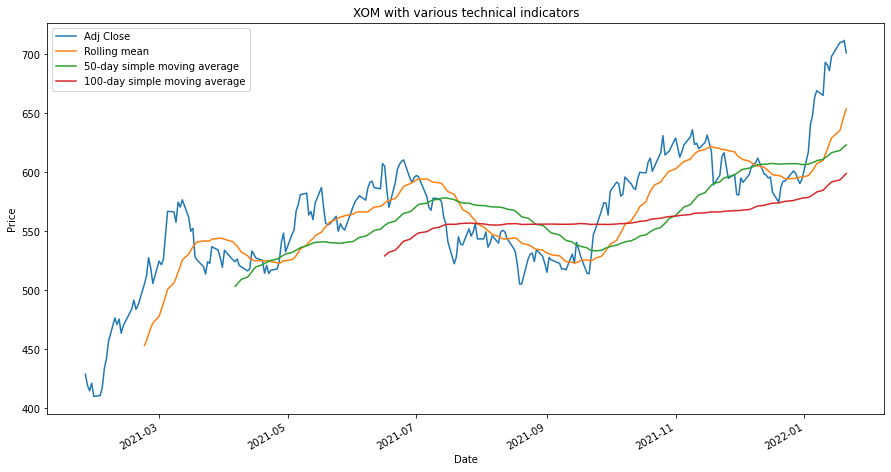

In [5]:
plt.figure(figsize=(15,8))

df_plot_data = pd.DataFrame(xom_data['Adj Close'].iloc[-252:])

# plot XOM data, retain matplotlib axis object as 'ax'
ax = df_plot_data['Adj Close'].plot(title="XOM with various technical indicators", label='Adj Close')

# compute rolling mean using a 20-day window
rolling_mean = get_rolling_mean(df_plot_data['Adj Close'], window=20)
sma_50 = get_rolling_mean(df_plot_data['Adj Close'], window=50)
sma_100 = get_rolling_mean(df_plot_data['Adj Close'], window=100)


# add rolling mean, and Bollinger Bands to same plot 'ax'
rolling_mean.plot(label='Rolling mean', ax=ax)
sma_50.plot(label='50-day simple moving average', ax=ax)
sma_100.plot(label='100-day simple moving average', ax=ax)


# add axis labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend(loc='upper left')

plt.show()

We explore the relationship of these technical indicators to the 'Adj Close' as of a future date to determine if these can be used as predictor variables in our analysis. We compare the relationship between these variables and the price 50 days into the future. We observe a high level of correlation between the future price and the technical indicators. We also observe a high level of multicollinearity between the variables but given that stock market participants pay close attention to these variables and in different market cycles these variables can have significant divergence in the short term we will still retain the features for our analysis.

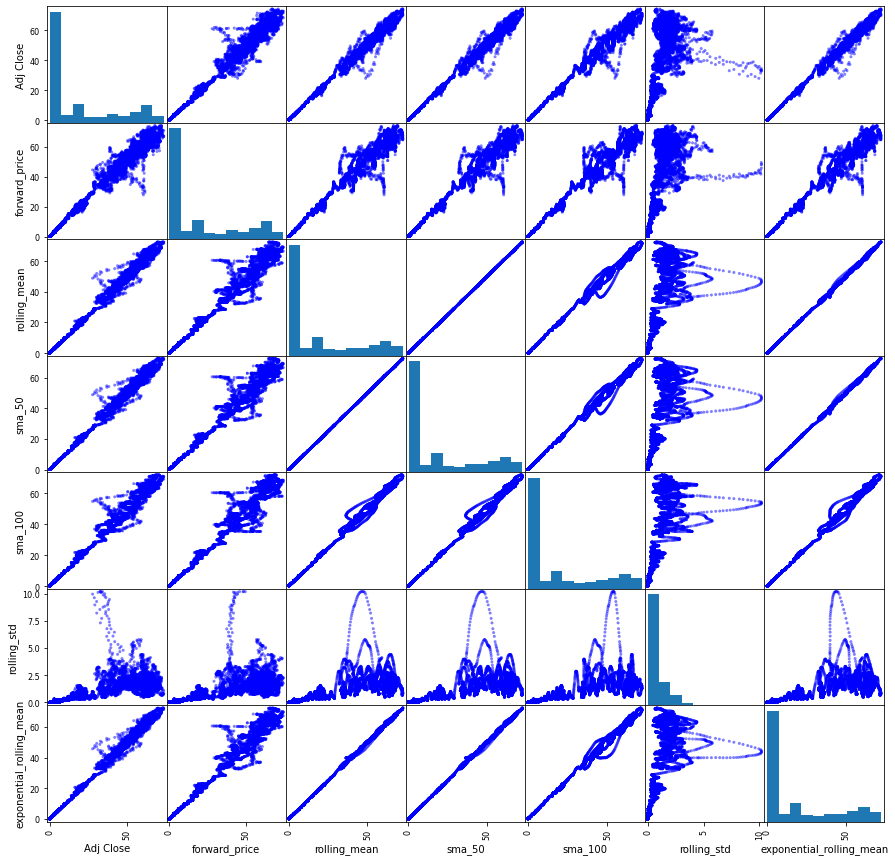

In [6]:
df_exploration = pd.DataFrame(df['XOM']['Adj Close'])

df_exploration = create_features(df_exploration, forecast_range=50)

smatrix = scatter_matrix(df_exploration, figsize=(15, 15), color='b')

In [7]:
df_exploration.corr()

,Adj Close,forward_price,rolling_mean,sma_50,sma_100,rolling_std,exponential_rolling_mean
Adj Close,1.000000,0.993195,0.997760,0.997760,0.995916,0.769873,0.998387
forward_price,0.993195,1.000000,0.991884,0.991884,0.990502,0.784376,0.992369
rolling_mean,0.997760,0.991884,1.000000,1.000000,0.998969,0.775900,0.999884
sma_50,0.997760,0.991884,1.000000,1.000000,0.998969,0.775900,0.999884
sma_100,0.995916,0.990502,0.998969,0.998969,1.000000,0.782265,0.999008
rolling_std,0.769873,0.784376,0.775900,0.775900,0.782265,1.000000,0.775843
exponential_rolling_mean,0.998387,0.992369,0.999884,0.999884,0.999008,0.775843,1.000000


## 5. Data Preprocessing and Featuring Engineering<a name="item5"></a>
<a href="#itemA">*`Table of content`*</a>

In [8]:
# this the number of days into the future the prediction should be made
# hard coded to 20 hear but will be a user input in the section 9. USER INTERFACE 
forecast_range = 20  

# Get the list of tickers for the multi-index column hierarchy
tickers = df.columns.get_level_values(0).unique()

# initialize dataframe to store the features
df_features = pd.DataFrame()

# loop through each ticker and call the create_features function to generate the features
for ticker in tickers: 
    ticker_id = ticker
    adj_close = df.columns.get_level_values(1)[4]
    df_adj_close = pd.DataFrame(df[ticker][adj_close])
    df_temp = create_features(df_adj_close, int(forecast_range))
    df_temp['Ticker'] = ticker
    print("\n", ticker)
    display(df_temp.head(3))
    
    df_features = pd.concat([df_features, df_temp])



 GOOG


,Adj Close,forward_price,rolling_mean,sma_50,sma_100,rolling_std,exponential_rolling_mean,Ticker
Date,,,,,,,,
2005-01-10,97.165802,98.949112,93.763052,90.512337,76.899263,4.019539,94.195688,GOOG
2005-01-11,96.408638,95.432297,94.338147,90.541229,77.363522,3.471140,94.406453,GOOG
2005-01-12,97.325203,93.639015,94.753839,90.534753,77.797247,3.292890,94.684440,GOOG



 MSFT


,Adj Close,forward_price,rolling_mean,sma_50,sma_100,rolling_std,exponential_rolling_mean,Ticker
Date,,,,,,,,
1986-08-04,0.061926,0.060830,0.063913,0.067692,0.066505,0.002578,0.064696,MSFT
1986-08-05,0.061378,0.059186,0.063776,0.067560,0.066505,0.002639,0.064380,MSFT
1986-08-06,0.060830,0.064119,0.063749,0.067374,0.066478,0.002668,0.064042,MSFT



 AAPL


,Adj Close,forward_price,rolling_mean,sma_50,sma_100,rolling_std,exponential_rolling_mean,Ticker
Date,,,,,,,,
1981-05-06,0.095649,0.112246,0.096960,0.091378,0.097571,0.003657,0.096439,AAPL
1981-05-07,0.096960,0.110499,0.097091,0.091553,0.097536,0.003605,0.096489,AAPL
1981-05-08,0.097833,0.106568,0.097178,0.091718,0.097562,0.003600,0.096617,AAPL



 XOM


,Adj Close,forward_price,rolling_mean,sma_50,sma_100,rolling_std,exponential_rolling_mean,Ticker
Date,,,,,,,,
1962-05-23,0.108140,0.102667,0.111604,0.111682,0.110221,0.001654,0.111109,XOM
1962-05-24,0.108661,0.101625,0.111354,0.111618,0.110278,0.001705,0.110876,XOM
1962-05-25,0.106315,0.101104,0.111026,0.111471,0.110296,0.002001,0.110442,XOM


In [9]:
df_features.head()

,Adj Close,forward_price,rolling_mean,sma_50,sma_100,rolling_std,exponential_rolling_mean,Ticker
Date,,,,,,,,
2005-01-10,97.165802,98.949112,93.763052,90.512337,76.899263,4.019539,94.195688,GOOG
2005-01-11,96.408638,95.432297,94.338147,90.541229,77.363522,3.471140,94.406453,GOOG
2005-01-12,97.325203,93.639015,94.753839,90.534753,77.797247,3.292890,94.684440,GOOG
2005-01-13,97.300293,93.350098,95.141137,90.539336,78.225292,3.098972,94.933577,GOOG
2005-01-14,99.611633,96.134666,95.726443,90.622026,78.699017,2.745794,95.379120,GOOG


## 6. Setting up learner class to help fit/train models and generate predictions<a name="item6"></a>
<a href="#itemA">*`Table of content`*</a>


In [10]:
##########################################################################################################

class StockPredictionLearner(object):
    
    """Trains and evaluates a stock prediction model given the model type and X and Y values.
       Also generates a prediction using the trained model
       
       Attributes: model (instantiated object) machine learning model specified e.g linear regression, SVM, KNN
                   X and Y (array) representing predictor variables and target variables 
    """
    
    def __init__(self, clf, params=None):
        self.clf = clf(**params)
        
    def train(self, X_train, Y_train):
        """Train a model given model object/type, independent (X) and dependent (Y) values (Y)
        
        Input: model   - instantiated model object
               X_train - array of predictor variables
               Y_train - array of target variables
        
        Output: A fitted linear regression model
        """
        
        self.clf.fit(X_train, Y_train)
                
    def predict(self, X_input):
        """ Returns a prediction (dependent variable) given the model and independent variables (X_input)
        Input: model - a trained linear regression model
               X_input - array of the independent variables to be used as predictors
        Output: array of predicted values based on the model and input values provided
        """
        
        return self.clf.predict(X_input)
    
    def fit(self,x,y):
        
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        
        print(self.clf.fit(x, y).feature_importances_)
        
#########################################################################################################

## 7. Setting up utility/helper functions for model training and evaluation<a name="item7"></a>
<a href="#itemA">*`Table of content`*</a>


In [11]:
def prepare_train_test_split(df):
    
    """Generates train_test_split for given dataframe"""
    
    X = np.array(df.drop(['forward_price', 'Ticker'], axis=1))
    y = np.array(df['forward_price'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
    
    return X_train, X_test, y_train, y_test, X, y

def train_k_folds(clf, X_train, y_train, X_test, X, y):
    """ Fits a model using K-fold cross validation
    
    Input: clf (object) instantiated model object
           X/y train/test (arrays) representing the train/test X/y data 
    
    Output: arrays of cross validation results
    
    """
    
    # Set K-Fold parameters
    ntrain = X_train.shape[0]
    ntest = X_test.shape[0]
    nfolds = 5 
    kf = KFold(n_splits=nfolds, shuffle=False)
    
    kf_train = np.zeros((ntrain,))
    kf_test = np.zeros((ntest,))
    kf_test_skf = np.empty((nfolds, ntest))
    
    i = 0
    
    for train_index, test_index in kf.split(X_train):
        i=+1
        x_tr, x_te = X_train[train_index], X[test_index]
        y_tr, y_te = y[train_index], y[test_index]
       
        clf.train(x_tr, y_tr)

        kf_train[test_index] = clf.predict(x_te)
        kf_test_skf[i, :] = clf.predict(X_test)

    kf_test[:] = kf_test_skf.mean(axis=0)
    
    return kf_train.reshape(-1, 1), kf_test.reshape(-1, 1)

def evaluate_model(model, X_test, Y_test):
    """ Returns scoring metrics to evaluate the performance of the model

    Input: model - a trained linear regression model
           X_test, Y_test - independent and dependent variables from the training dataset

    Output: r-squared, mean squared error, root mean squared error, 
            mean absolute error, mean absolute percentage error 
    """
    
    y_pred = model.predict(X_test)
    
    r_squared = r2_score(Y_test, y_pred)
    mse = mean_squared_error(Y_test, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(Y_test, y_pred)
    mape = mean_absolute_percentage_error(Y_test, y_pred)

    return r_squared, mse, rmse, mae, mape
    
def print_evaluation(result):
    
    """Prints the results for the evaluation of the model performed in the evaluate_model function
    
    Input: result (list/tuple) containing the r_squared, mse, rmse, mae, mape
    
    Output: None (performs print action)
    """
    r_squared, mse, rmse, mae, mape = result[0], result[1], result[2], result[3], result[4]
   
    print("R-squared:\t {:.2f}".format(r_squared))
    print("MSE:\t\t {:.2f}".format(mse))
    print("RMSE:\t\t {:.2f}".format(rmse))
    print("MAE:\t\t {:.2f}".format(mae))
    print("MAPE:\t\t {:.1%}".format(mape))
    print("\n")
    

## 8. Training and evaluating the models<a name="item8"></a>
<a href="#itemA">*`Table of content`*</a>


In [12]:
# Set model paramenters
ln_params = {}  # Linear Regression
kr_params = {'alpha': 1.0} # Kernel Ridge Regression
sgd_params = {'max_iter': 1000, 'tol': 1e-3} # Stochastic Gradient Descent
svr_params = {'max_iter':10000} # Linear Support Vector Regression
knn_params = {'n_neighbors':3} # K-nearest neighbor Regression

# Set up object for each models
ln_reg = StockPredictionLearner(clf=linear_model.LinearRegression, params=ln_params)
kr = StockPredictionLearner(clf=KernelRidge, params=kr_params)
sgd = StockPredictionLearner(clf=SGDRegressor, params=sgd_params)
ln_svr = StockPredictionLearner(clf=LinearSVR, params=svr_params)
knn = StockPredictionLearner(clf=KNeighborsRegressor, params=knn_params)


# set up dictionary to be used to loop through the evaluation results of each model
models = {"Linear Regression": ln_reg,
          "Kernel Ridge Regression": kr,
          "Stochastic Gradient Descent": sgd,
          "Linear Support Vector Regression": ln_svr, 
          "K-nearest neighbor (KNN) Regression": knn
         }


In [13]:
def train_test_evaluate(df_data):
    
    """Combines the prepare_train_test_split, train_k_folds, evaluate_model functions above
    to complete the training and testing cycles and recommend the best model to be use for 
    prediction for each ticker provided
    
    Input: df_data (dataframe) representing dataset to be used for training and testing
    
    Output: best_models (dict) representing the model that should be used to generate predictions of each ticker
    
    """
        
    best_models = dict() # set up dictionary to store the best model for each ticker

    for ticker in tickers: # train each model for each ticker in the list of tickers requested

        df_temp_ticker = df_data[df_data['Ticker'] == ticker]

        # generate train/test split using the prepare_train_test_split function 
        # prepare_train_test_split function defined in set-up section above
        X_train, X_test, y_train, y_test, X, y = prepare_train_test_split(df_temp_ticker)

        # Train and test models by calling the train_k_folds defined in the set-up section above
        ln_train, ln_test = train_k_folds(ln_reg, X_train, y_train, X_test, X, y) # Linear Regression
        kr_train, kr_test = train_k_folds(kr, X_train, y_train, X_test, X, y) # Kernel Ridge Regression
        sgd_train, sgd_test = train_k_folds(sgd, X_train, y_train, X_test, X, y) # Stochastic Gradient Descent
        svr_train, svr_test = train_k_folds(ln_svr, X_train, y_train, X_test, X, y) # Linear Support Vector Regression
        knn_train, knn_test = train_k_folds(knn, X_train, y_train, X_test, X, y) # K-nearest neighbor Regression


        print("Training completed for {}\n".format(ticker))

        # set up dataframe to store the evaluation results of each model
        df_results = pd.DataFrame(columns=['R-Squared', 'MSE', 'RMSE', 'MAE', 'MAPE'])

        # loop through the testing results of each model and add results to the dataframe
        for model_name, model_obj in models.items():
            df_results.loc[model_name] = list(evaluate_model(model_obj, X_test, y_test))

        display(df_results)

        # identify the best model (model with lowest RSME)
        best_model_name = df_results['RMSE'].idxmin()   
        best_models[ticker] = best_model_name

        print("The best model for {} is the \033[1m {} \033[1m\033[0m model\n\n".format(ticker, best_model_name))

    print("Training and evaluation completed successfully for all tickers and all models!")
    
    return best_models


In [14]:
# Call train_test_evaluate function above to train and test
# and get results for best model to use

model_to_use_for_prediction = train_test_evaluate(df_features)

Training completed for GOOG



,R-Squared,MSE,RMSE,MAE,MAPE
Linear Regression,9.616707e-01,1.495812e+04,1.223034e+02,9.139346e+01,5.564993e-02
Kernel Ridge Regression,9.635357e-01,1.423032e+04,1.192909e+02,8.866370e+01,5.443663e-02
Stochastic Gradient Descent,-1.201577e+24,4.689191e+29,6.847767e+14,6.477925e+14,3.911058e+11
Linear Support Vector Regression,9.627289e-01,1.454515e+04,1.206033e+02,8.960778e+01,5.504126e-02
K-nearest neighbor (KNN) Regression,-2.249363e+00,1.268073e+06,1.126088e+03,9.369207e+02,5.023894e-01


The best model for GOOG is the  Kernel Ridge Regression  model


Training completed for MSFT



,R-Squared,MSE,RMSE,MAE,MAPE
Linear Regression,9.850187e-01,1.009501e+02,1.004739e+01,6.608836e+00,0.050497
Kernel Ridge Regression,9.868255e-01,8.877498e+01,9.422047e+00,6.136736e+00,0.047285
Stochastic Gradient Descent,-1.087892e+11,7.330637e+14,2.707515e+07,1.891042e+07,156460.069732
Linear Support Vector Regression,9.856849e-01,9.646054e+01,9.821433e+00,6.393897e+00,0.049090
K-nearest neighbor (KNN) Regression,-1.207380e+00,1.487419e+04,1.219598e+02,9.028940e+01,0.603479


The best model for MSFT is the  Kernel Ridge Regression  model


Training completed for AAPL



,R-Squared,MSE,RMSE,MAE,MAPE
Linear Regression,0.982253,30.423591,5.515758,3.488243,0.063445
Kernel Ridge Regression,0.982630,29.777560,5.456882,3.445058,0.061827
Stochastic Gradient Descent,0.981072,32.449531,5.696449,3.574460,0.065914
Linear Support Vector Regression,0.981766,31.258345,5.590916,3.501798,0.063952
K-nearest neighbor (KNN) Regression,-1.571228,4407.937928,66.392303,51.899962,0.903776


The best model for AAPL is the  Kernel Ridge Regression  model


Training completed for XOM



,R-Squared,MSE,RMSE,MAE,MAPE
Linear Regression,0.843355,14.362693,3.789814,2.725567,0.050918
Kernel Ridge Regression,0.842338,14.455971,3.802101,2.737166,0.051131
Stochastic Gradient Descent,0.796583,18.651187,4.318702,3.242035,0.060134
Linear Support Vector Regression,0.852200,13.551688,3.681262,2.657366,0.049413
K-nearest neighbor (KNN) Regression,-16.322418,1588.281889,39.853254,38.685011,0.650038


The best model for XOM is the  Linear Support Vector Regression  model


Training and evaluation completed successfully for all tickers and all models!


In [15]:
# display summary of the best model for each ticker symbol 
# based on the results of the train/test/evaluate cycle above

model_to_use_for_prediction

{'GOOG': 'Kernel Ridge Regression',
 'MSFT': 'Kernel Ridge Regression',
 'AAPL': 'Kernel Ridge Regression',
 'XOM': 'Linear Support Vector Regression'}

## 9.USER INTERFACE<a name="item9"></a>
<a href="#itemA">*`Table of content`*</a> 


### Generating a prediction

If suggestions for valid ticker symbols are needed, execute this code cell to get the list of ticker symbols for stocks in the S&P 500 index. Yahoo Finance requires the ticker symbol to be provided as the identifier in order to download stock price data using the API

In [16]:
# Get list of S&P 500 stocks

# Import table of S&P 500 stocks from wikipedia
sp500_universe = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# replace "." with "-" in ticker symbols to conform with yahoo finance format
# for example "BRK.B" should be converted to "BRK-B"
sp500_universe['Symbol'] = sp500_universe['Symbol'].replace(regex=r"[.]", value="-")

display(sp500_universe.head())
print(list(sp500_universe['Symbol']))

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AAP', 'AES', 'AFL', 'A', 'AIG', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL', 'BAC', 'BBWI', 'BAX', 'BDX', 'BRK-B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF-B', 'CHRW', 'CDNS', 'CZR', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CDAY', 'CERN', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 'CTVA', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', '

### 9a. Get user input on the list of ticker symbols for the stocks for which predictions are required<a name="item9a"></a>
<a href="#itemA">*`Table of content`*</a> 



In [17]:
# import data from yahoo finance using the get_data helper function created above

try:
    # request list of ticker symbols from user
    ticker_input = input("Enter list of ticker symbols:---->  ")
    tickers = format_tickers(ticker_input) # clean user entry to required format for yahoo finance using clean_tickers helper function

    print("\n")

    # get stock data from yahoo finance using get_data function above
    df1 = get_data(tickers)

    # print number of rows in dataset
    print("\nThere are {} tradings days worth of data\n".format(df.shape[0]))

    display(df1.head())

except:
    print("\nPlease enter valid ticker symbols. Check list of S&P 500 constituents above if you need ticker examples")


Enter list of ticker symbols:---->  jpm, c, brk-b, tsla


[*********************100%***********************]  4 of 4 completed

There are 15119 tradings days worth of data



TSLA                                 BRK-B                 ... JPM  \
           Open High Low Close Adj Close Volume  Open High Low Close  ... Low   
Date                                                                  ...       
1977-01-03  NaN  NaN NaN   NaN       NaN    NaN   NaN  NaN NaN   NaN  ... NaN   
1977-01-04  NaN  NaN NaN   NaN       NaN    NaN   NaN  NaN NaN   NaN  ... NaN   
1977-01-05  NaN  NaN NaN   NaN       NaN    NaN   NaN  NaN NaN   NaN  ... NaN   
1977-01-06  NaN  NaN NaN   NaN       NaN    NaN   NaN  NaN NaN   NaN  ... NaN   
1977-01-07  NaN  NaN NaN   NaN       NaN    NaN   NaN  NaN NaN   NaN  ... NaN   

                                           C                                   \
           Close Adj Close Volume       Open       High        Low      Close   
Date                                                                            
1977-01-03   NaN       NaN    NaN  16.133125  16.236876  16.133125  16.236876   
1977-01-04   NaN       NaN    NaN  16.236876  16.288750  16.184999  16.288750   
1977-01-05   NaN       NaN    NaN  16.288750  16.288750  16.133125  16.184999   
1977-01-06   NaN       NaN    NaN  16.133125  16.133125  15.925625  16.081249   
1977-01-07   NaN       NaN    NaN  16.081249  16.133125  15.925625  16.133125   

                             
           Adj Close Volume  
Date                         
1977-01-03  7.757818  47952  
1977-01-04  7.782605  34217  
1977-01-05  7.733037  15422  
1977-01-06  7.683464  39036  
1977-01-07  7.708250  20482  

[5 rows x 24 columns]

### 9b. Get user input on the date range to be used for training and testing<a name="item9b"></a>
<a href="#itemA">*`Table of content`*</a> 



In [18]:
print("The stocks you have selected have data from {:%Y-%m-%d} to {:%Y-%m-%d}\n".format(df1.index[0], df1.index[-1]))

train_start = input("Enter the training start date in the same format (yyyy-mm-dd):---->  ")
train_end = input("Enter the training end date in the same format (yyyy-mm-dd):---->  ") 
msg_try_again = "*****Please try again*****"

try:
    train_start = datetime.strptime(train_start, '%Y-%m-%d')
    train_end = datetime.strptime(train_end, '%Y-%m-%d')
    if df1.index[0] < train_start < df1.index[-1]:
        if df1.index[0] < train_end < df1.index[-1]:
            print("\nTraining and testing will be completed over the period from {:%Y-%m-%d} to {:%Y-%m-%d}".format(train_start, train_end))
        else:
            print("\nThe training end date provided in out of range")
            print(msg_try_again)
    else:
        print("\nThe training start date provided in out of range")
        print(msg_try_again)        
except:
    print("\nPlease enter dates in valid date format (yyyy-mm-dd)")
    print(msg_try_again)   


The stocks you have selected have data from 1977-01-03 to 2022-01-21

Enter the training start date in the same format (yyyy-mm-dd):---->  2010-01-01
Enter the training end date in the same formate (yyyy-mm-dd):---->  2020-12-31

Training and testing will be completed over the period from 2010-01-01 to 2020-12-31


### 9c. Get user input on the number of days into future they wish to make a prediction and create features using this forecast range<a name="item9c"></a>
<a href="#itemA">*`Table of content`*</a> 

In [19]:

forecast_range = input("Enter number of days into the future for which stock prediction is requested:---->  ")

try:
    forecast_range = int(forecast_range)
    
    max_train_date = df1.index[-1] - timedelta(days=forecast_range)
    
    if train_end <= max_train_date:
 
        tickers = df1.columns.get_level_values(0).unique()    
        df1_features = pd.DataFrame()    

        for ticker in tickers: 
            ticker_id = ticker
            adj_close = df1.columns.get_level_values(1)[4]
            df_adj_close = pd.DataFrame(df1[ticker][adj_close])
            df_temp = create_features(df_adj_close, int(forecast_range))
            df_temp['Ticker'] = ticker
            print("\n", ticker)
            display(df_temp.head(3))
            df1_features = pd.concat([df1_features, df_temp])
    else:
        max_delta = df1.index[-1] - train_end
        print("\nThe training end date does not allow for sufficient testing for forecast period of {} days".format(forecast_range))
        print("The maximum forecast range that can be selected is {} days".format(max_delta.days))
        print(msg_try_again)

except:
    print("Enter valid number of days for which stock prediction is required")
    print(msg_try_again)


Enter number of days into the future for which stock prediction is requested:---->  28

 TSLA


,Adj Close,forward_price,rolling_mean,sma_50,sma_100,rolling_std,exponential_rolling_mean,Ticker
Date,,,,,,,,
2010-11-17,5.898,5.546,4.653786,4.42844,4.19758,0.728183,4.908231,TSLA
2010-11-18,5.978,5.300,4.722714,4.46516,4.20958,0.759393,4.982062,TSLA
2010-11-19,6.198,5.326,4.799500,4.50844,4.22390,0.796437,5.065977,TSLA



 BRK-B


,Adj Close,forward_price,rolling_mean,sma_50,sma_100,rolling_std,exponential_rolling_mean,Ticker
Date,,,,,,,,
1996-09-30,21.459999,21.860001,21.310000,21.1364,21.3232,0.288778,21.365822,BRK-B
1996-10-01,21.240000,21.879999,21.311428,21.1444,21.3036,0.288312,21.357138,BRK-B
1996-10-02,21.420000,21.920000,21.315714,21.1648,21.2778,0.289027,21.361477,BRK-B



 JPM


,Adj Close,forward_price,rolling_mean,sma_50,sma_100,rolling_std,exponential_rolling_mean,Ticker
Date,,,,,,,,
1980-08-06,1.384274,1.443540,1.401358,1.384443,1.314890,0.039418,1.399691,JPM
1980-08-07,1.405439,1.447772,1.403021,1.385628,1.317430,0.038531,1.400088,JPM
1980-08-08,1.396974,1.452006,1.404533,1.386983,1.319801,0.037376,1.399873,JPM



 C


,Adj Close,forward_price,rolling_mean,sma_50,sma_100,rolling_std,exponential_rolling_mean,Ticker
Date,,,,,,,,
1977-05-24,7.980890,8.005672,7.932204,7.910003,7.831929,0.070583,7.944351,C
1977-05-25,8.005672,8.055242,7.929549,7.912482,7.834408,0.066070,7.948583,C
1977-05-26,7.980890,8.129598,7.932204,7.913473,7.836391,0.066603,7.950813,C


### 9d. Train model and get back results of the best model to use given the date range specified for training and the number of days into future that the user wishes to predict<a name="item9d"></a>
<a href="#itemA">*`Table of content`*</a> 

In [20]:
model_recommendation = train_test_evaluate(df1_features)

Training completed for TSLA



,R-Squared,MSE,RMSE,MAE,MAPE
Linear Regression,8.328477e-01,1.679059e+04,1.295785e+02,9.274111e+01,2.085921e-01
Kernel Ridge Regression,8.381626e-01,1.625670e+04,1.275018e+02,9.106709e+01,2.050850e-01
Stochastic Gradient Descent,-1.165991e+22,1.171247e+27,3.422349e+13,2.849790e+13,5.387524e+10
Linear Support Vector Regression,8.296394e-01,1.711286e+04,1.308161e+02,9.318078e+01,2.085156e-01
K-nearest neighbor (KNN) Regression,-2.023426e+00,3.037056e+05,5.510949e+02,4.513469e+02,7.619203e-01


The best model for TSLA is the  Kernel Ridge Regression  model


Training completed for BRK-B



,R-Squared,MSE,RMSE,MAE,MAPE
Linear Regression,8.298764e-01,2.261764e+02,1.503916e+01,1.160403e+01,5.356250e-02
Kernel Ridge Regression,8.706115e-01,1.720197e+02,1.311563e+01,9.723025e+00,4.545910e-02
Stochastic Gradient Descent,-2.104541e+21,2.797951e+24,1.672708e+12,1.645111e+12,7.736379e+09
Linear Support Vector Regression,8.043559e-01,2.601054e+02,1.612778e+01,1.283597e+01,5.913855e-02
K-nearest neighbor (KNN) Regression,-1.193517e+01,1.719707e+04,1.311376e+02,1.259704e+02,5.772105e-01


The best model for BRK-B is the  Kernel Ridge Regression  model


Training completed for JPM



,R-Squared,MSE,RMSE,MAE,MAPE
Linear Regression,0.947332,6.416254e+01,8.010152,5.269022,0.058130
Kernel Ridge Regression,0.948586,6.263492e+01,7.914223,5.161315,0.057112
Stochastic Gradient Descent,-38275.855977,4.663055e+07,6828.656528,4659.990940,53.045365
Linear Support Vector Regression,0.951913,5.858151e+01,7.653856,4.932546,0.055316
K-nearest neighbor (KNN) Regression,-2.191364,3.887860e+03,62.352710,51.668331,0.527610


The best model for JPM is the  Linear Support Vector Regression  model


Training completed for C



,R-Squared,MSE,RMSE,MAE,MAPE
Linear Regression,7.409668e-01,3.227067e+01,5.680728e+00,3.615112e+00,7.244073e-02
Kernel Ridge Regression,7.471619e-01,3.149888e+01,5.612386e+00,3.660991e+00,7.257076e-02
Stochastic Gradient Descent,-3.427253e+20,4.269714e+22,2.066329e+11,1.496450e+11,2.917669e+09
Linear Support Vector Regression,4.265374e-01,7.144268e+01,8.452377e+00,6.385739e+00,1.282396e-01
K-nearest neighbor (KNN) Regression,9.842159e-02,1.123197e+02,1.059810e+01,7.840758e+00,1.517789e-01


The best model for C is the  Kernel Ridge Regression  model


Training and evaluation completed successfully for all tickers and all models!


In [21]:
# display the summary of models to be used to generate prediction

model_recommendation

{'TSLA': 'Kernel Ridge Regression',
 'BRK-B': 'Kernel Ridge Regression',
 'JPM': 'Linear Support Vector Regression',
 'C': 'Kernel Ridge Regression'}

### 9e. Get user input on the date for which prediction should be generated<a name="item9e"></a>
<a href="#itemA">*`Table of content`*</a> 

In [22]:
max_prediction_date = df1.index[-1] - timedelta(days=forecast_range)

print("Enter a date between {:%Y-%m-%d} and {:%Y-%m-%d} for which a prediction is required\n".format(train_end, max_prediction_date))

user_prediction_date = input("Enter date in the format yyyy-mm-dd:---->  ")

try:
    user_prediction_date = datetime.strptime(user_prediction_date, '%Y-%m-%d')
    if train_end < user_prediction_date < max_prediction_date:
        
        print("\nThank you! Proceed to the final step to generate your prediction")
    else:
        print("\nThe prediction date provided in out of range")
        print(msg_try_again)        
except:
    print("\nPlease enter a valid date in the format (yyyy-mm-dd)")
    print(msg_try_again)   


Enter a date between 2020-12-31 and 2021-12-24 for which a prediction is required

Enter date in the format yyyy-mm-dd:---->  2021-06-30

Thank you! Proceed to the final step to generate your prediction


### 9f. Finally, generate and present prediction for date specified by user<a name="item9f"></a>
<a href="#itemA">*`Table of content`*</a> 

In [23]:
# X_input_date is the reference date for which predictor values should be retrieved
X_input_date = user_prediction_date - timedelta(days=forecast_range)
X_input_date = X_input_date.strftime('%Y-%m-%d')

# check if the date n-days before prediction date was a day
# if not then check the previous day until a valid trading day is found
# 4 (range (5)) used as the maximum continuous period for scenarios with 2 public holidays on either side of a weekend 

rng_count = forecast_range # counter to move back one day if calculated prediction date was not a trading day

# attempt to get X/predictor values using X_input_date
# if successful then row found in dataset hence break loop
for i in range(5):
    
    X_input = df1_features.loc[X_input_date, :]
    
    if len(X_input) == 0:
        # if attempt to get X/predictor values from X_input_date fails
        # then set X_input_date to the previous day
        # until a valid trading day is found and X_input_date is set to that date in else statement
        X_input_date = user_prediction_date - timedelta(days=rng_count)
        X_input_date = X_input_date.strftime('%Y-%m-%d')
    else:
        prediction_date = X_input_date
        break
        
    rng_count = rng_count + 1   

# initial dictionary to store prediction results    
predicted_prices = dict()

# loop through each ticker and generate prediction
# also calculate the error and the percentage error (absolute)

for ticker in tickers:
    # Get the prediction model to be used
    prediction_model = models[model_recommendation[ticker]]
    
    # the data for the date to be predicted
    data = pd.DataFrame(df1_features[df1_features['Ticker'] == ticker].loc[prediction_date, :]).T
    X_input = np.array(data.drop(['forward_price', 'Ticker'], axis=1))
    actual = np.array(data['forward_price'])
    
    ### ******generate predictions and store results in predicted_prices dict****** ###
    prediction = prediction_model.predict(X_input)
    error = actual[0] - prediction[0]
    perct_error = abs(error)/actual[0]
    predicted_prices[ticker] = (prediction[0], actual[0], error, perct_error)
    
# display results as a dataframe    
columns = ['Actual Price', 'Predicted Price', 'Error', 'Percent Error']
df_predictions = pd.DataFrame.from_dict(predicted_prices, orient='index', columns=columns)     
df_predictions

,Actual Price,Predicted Price,Error,Percent Error
TSLA,647.146594,668.539978,21.393384,0.032000
BRK-B,286.943506,279.209991,-7.733515,0.027698
JPM,178.464713,153.795807,-24.668906,0.160400
C,77.697041,67.374977,-10.322064,0.153203
